In [1]:
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [2]:
# Generator
def gen_block(x, filters = 128, kernel_size = 5, strides = 2, padding = "same"):
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
    return x

def build_generator(inputs, labels, codes, image_size):
  image_resize = image_size // 4
  inputs = [inputs, labels] + codes
  x = concatenate(inputs, axis = 1)
  x = Dense(image_resize * image_resize * 128)(x)
  x = Reshape((image_resize, image_resize, 128))(x)
  x = gen_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 32, kernel_size = 5, strides = 1, padding = "same")
  x = gen_block(x = x, filters = 1, kernel_size = 5, strides = 1, padding = "same")
  x = Activation('sigmoid')(x)
  generator = Model(inputs, x, name = "generator")
  return generator

# Discriminator
def disc_block(x, filters = 64, kernel_size = 5, strides = 2, padding = "same"):
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
  return x

def build_discriminator(inputs, num_labels, num_codes):
   x = inputs
   x = LeakyReLU(alpha = 0.2)(x)
   x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(x)
   x = disc_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 256, kernel_size = 5, strides = 1, padding = "same")
   x = Flatten()(x)
   outputs = Dense(1)(x)
   outputs = Activation("sigmoid")(outputs) # until here, this part estimate the prob of the input being real

   # Info gan structure - auxiliary network Q
   ### 1. Auxilliary connection one-hot label output
   layer = Dense(128)(x)
   labels = Dense(num_labels)(layer)
   labels = Activation("softmax", name = 'label')(labels)

   ## Continuos codes for controlling rotation and thickness of the digits
   code1 = Dense(1)(layer)
   code1 = Activation('sigmoid', name='code1')(code1)

   code2 = Dense(1)(layer)
   code2 = Activation('sigmoid', name='code2')(code2)

   outputs = [outputs, labels, code1, code2]

   discriminator = Model(inputs, outputs, name = 'discriminator')
   return discriminator

11490434/11490434 [==============================] - 2s 0us/step


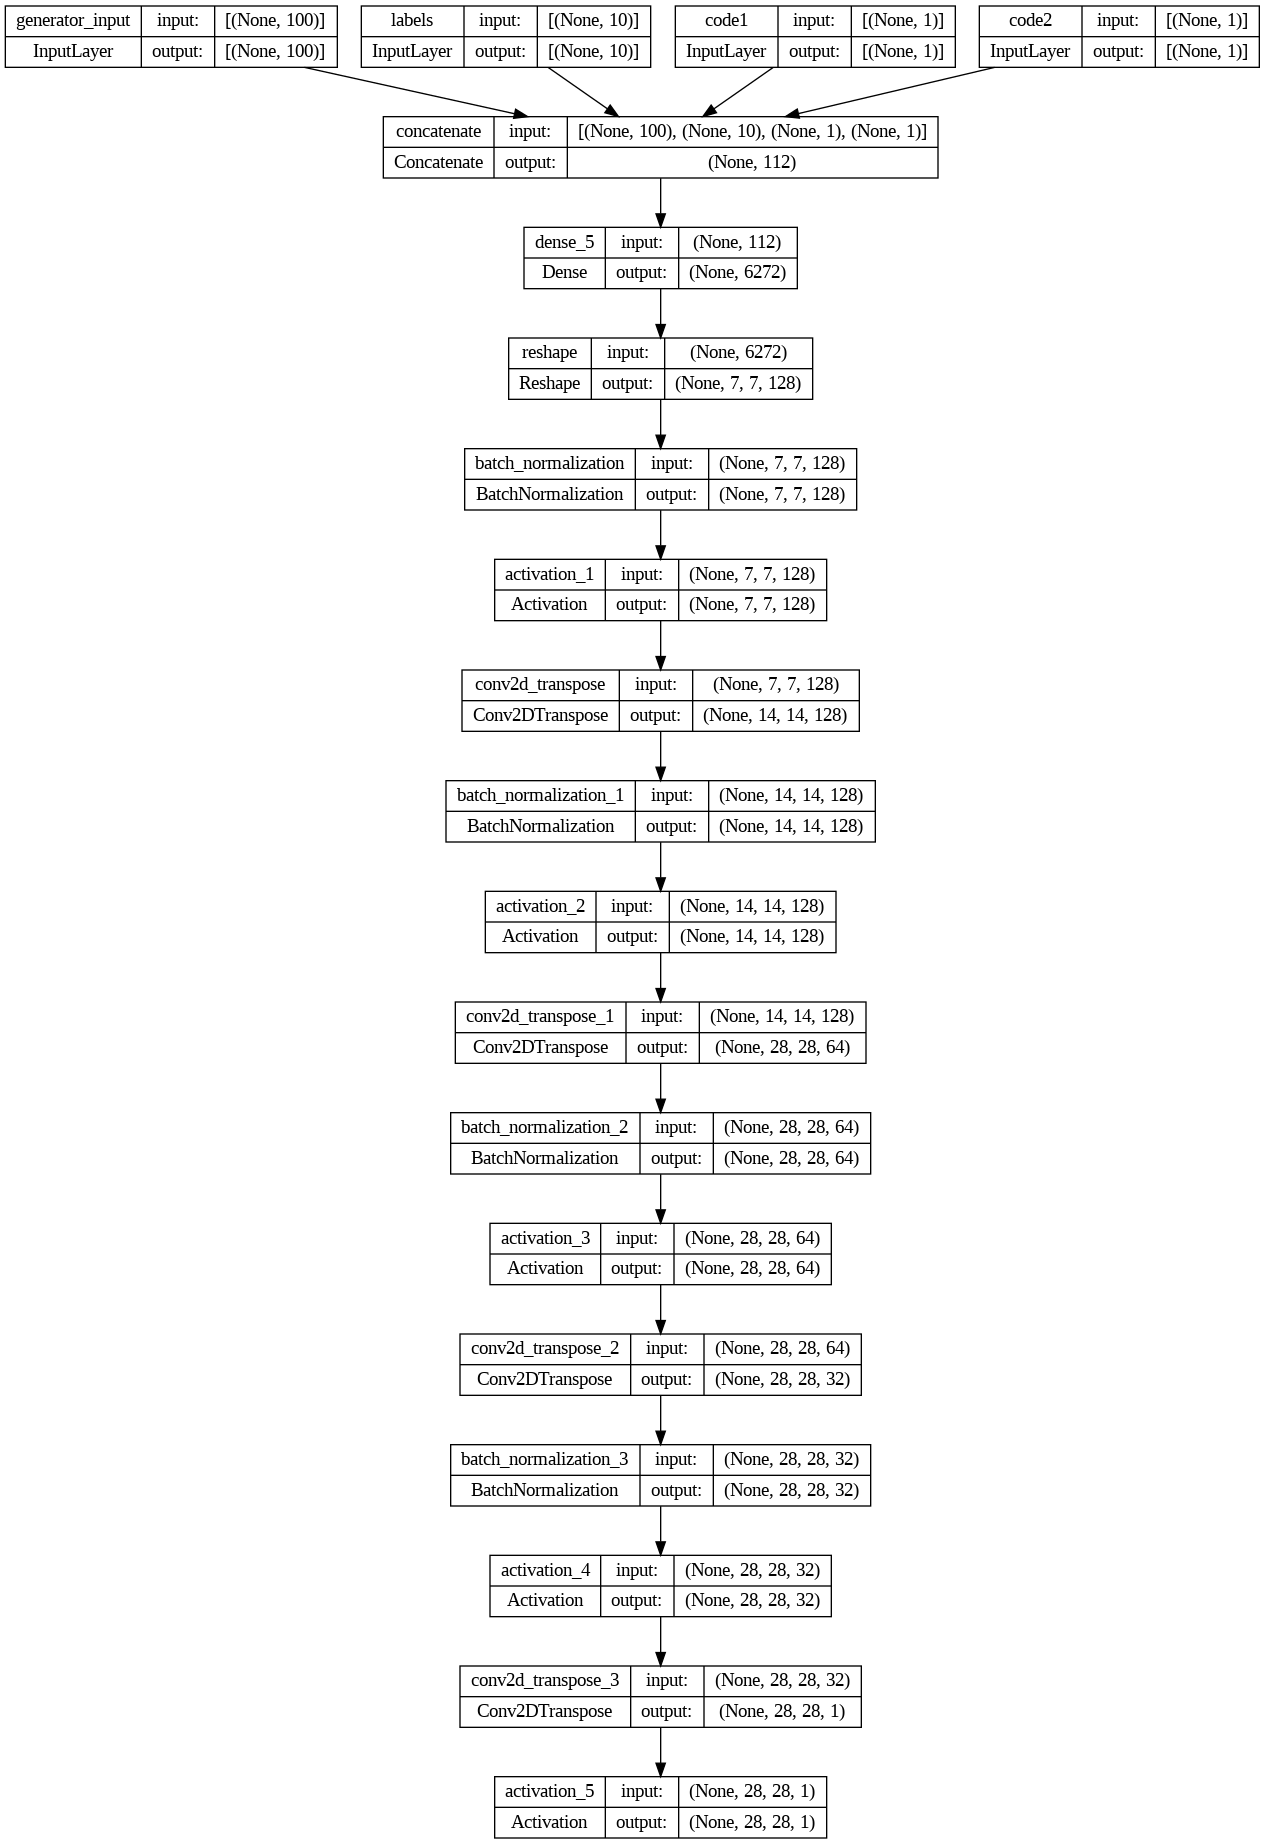

In [3]:
(x_train, y_train), (_ , _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

model_name = "infogan_mnist"
latent_size = 100 # latent vector of 100-dim
batch_size = 64
lr = 2e-4
decay = 6e-8
train_steps = 10000 # one can train for more number of steps to get better quality
input_shape = (image_size, image_size, 1)
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
label_shape = (num_labels,)
code_shape = (1,)

# loss for the codes
def mi_loss(c, q_c_x):
    # mi_loss = -c * log(Q(c|x))
    return -K.mean(K.sum(c * K.log(q_c_x + K.epsilon()),
                                   axis=1))

# discriminator model
inputs = Input(shape = input_shape, name = "discriminator_input")
discriminator = build_discriminator(inputs, num_labels = num_labels, num_codes = 2)
loss_weights = [1.0, 1.0, 0.5, 0.5]
discriminator.compile(loss = ["binary_crossentropy", "categorical_crossentropy", mi_loss, mi_loss],
                      loss_weights = loss_weights,
                      optimizer = RMSprop(learning_rate = lr, weight_decay = decay),
                      metrics = ['accuracy'])

# generator model
input_shape = (latent_size,)
inputs = Input(shape = input_shape, name = 'generator_input')
labels = Input(shape = label_shape, name = "labels")
code1 = Input(shape=code_shape, name="code1")
code2 = Input(shape=code_shape, name="code2")
generator = build_generator(inputs = inputs, labels = labels, codes = [code1, code2], image_size = image_size)

# adversarial model
discriminator.trainable = False
adversarial = Model([inputs, labels, code1, code2], discriminator(generator([inputs, labels, code1, code2])), name = model_name)
adversarial.compile(loss = ["binary_crossentropy", "categorical_crossentropy", mi_loss, mi_loss],
                    loss_weights = loss_weights,
                    optimizer = RMSprop(learning_rate = lr * 0.5, weight_decay = decay * 0.5),
                    metrics = ['accuracy'])


# plot the structure
plot_model(generator, show_shapes = True)

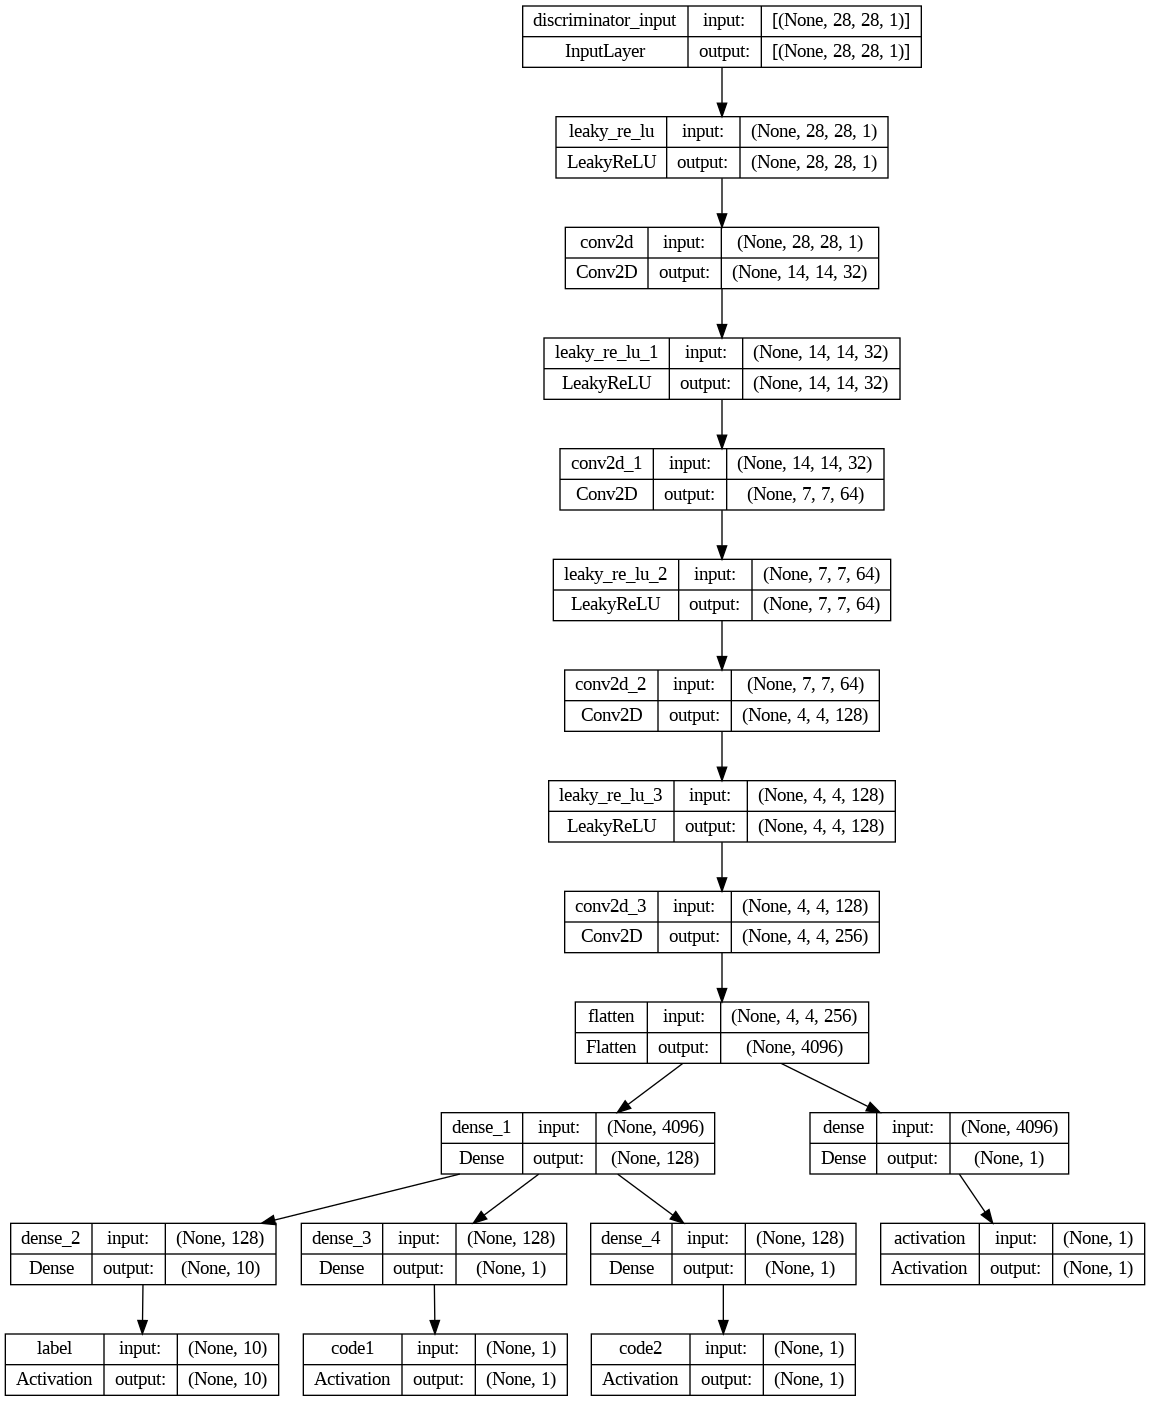

In [4]:
plot_model(discriminator, show_shapes = True)

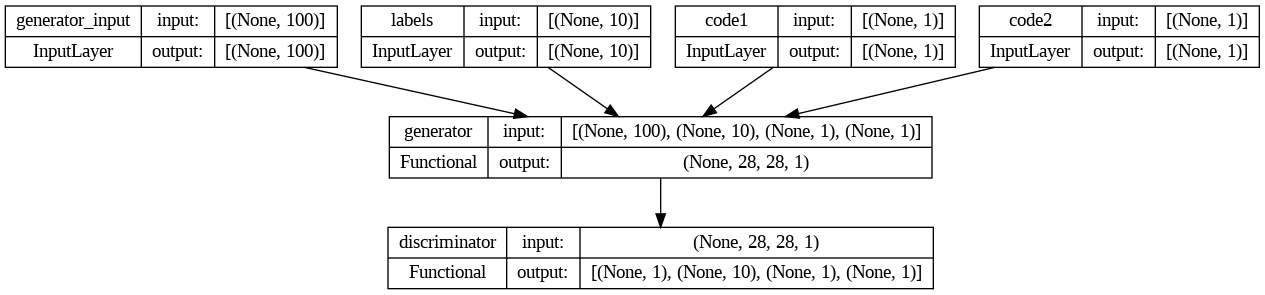

In [5]:
plot_model(adversarial, show_shapes = True)

In [6]:
def train(models, data, params):

  generator, discriminator, adversarial = models
  x_train, y_train = data
  batch_size, latent_size, train_steps, num_labels, model_name = params
  save_interval = 500
  code_std = 0.5
  noise_input = np.random.uniform(-1.0, 1.0, size = [16, latent_size])
  noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
  noise_code1 = np.random.normal(scale=code_std, size=[16, 1])
  noise_code2 = np.random.normal(scale=code_std, size=[16, 1])
  train_size = x_train.shape[0]
  print(model_name, "Labels for generated images:", np.argmax(noise_label, axis = 1))

  for i in range(train_steps):
    rand_indexes = np.random.randint(0, train_size, size = batch_size)
    real_images = x_train[rand_indexes]
    real_labels = y_train[rand_indexes]
    real_code1 = np.random.normal(scale=code_std, size=[batch_size, 1])
    real_code2 = np.random.normal(scale=code_std, size=[batch_size, 1])

    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
    fake_code1 = np.random.normal(scale=code_std, size=[batch_size, 1])
    fake_code2 = np.random.normal(scale=code_std, size=[batch_size, 1])
    inputs = [noise, fake_labels, fake_code1, fake_code2]
    fake_images = generator.predict(inputs)

    x = np.concatenate((real_images, fake_images))  # 1 batch of training data
    labels = np.concatenate((real_labels, fake_labels))
    codes1 = np.concatenate((real_code1, fake_code1))
    codes2 = np.concatenate((real_code2, fake_code2))

    y = np.ones([2 * batch_size, 1])
    y[batch_size:, :] = 0
    outputs = [y, labels, codes1, codes2]

    metrics = discriminator.train_on_batch(x, outputs)
    log = f"{i}: [dis: {metrics[0]:.6f}, bce: {metrics[1]:.6f}, ce: {metrics[2]:.6f}, mi: {metrics[3]:.6f}, mi: {metrics[4]:.6f}, acc: {metrics[6]:.6f}]"
    print(log)


    # train adversarial
    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
    fake_code1 = np.random.normal(scale=code_std, size=[batch_size, 1])
    fake_code2 = np.random.normal(scale=code_std, size=[batch_size, 1])
    y = np.ones([batch_size, 1])
    inputs = [noise, fake_labels, fake_code1, fake_code2]
    outputs = [y, fake_labels, fake_code1, fake_code2]
    metrics = adversarial.train_on_batch(inputs, outputs)
    log = f"{i}: [Adv: {metrics[0]:.6f}, bce: {metrics[1]:.6f}, ce: {metrics[2]:.6f}, mi: {metrics[3]:.6f}, mi: {metrics[4]:.6f}, acc: {metrics[6]:.6f}]"
    print(log)

    if (i + 1) % save_interval == 0:
      os.makedirs(model_name, exist_ok=True)
      filename = os.path.join(model_name, f"{i + 1:05d}.png")
      noise_codes=[noise_code1, noise_code2]
      images = generator.predict([noise_input, noise_label, noise_codes])
      plt.figure(figsize=(2.2, 2.2))
      num_images = images.shape[0]
      image_size = images.shape[1]
      rows = int(math.sqrt(noise_input.shape[0]))
      for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
      plt.savefig(filename)
      plt.show()

    if (i + 1) % (2 * save_interval) == 0:
      generator.save(model_name + ".keras")

infogan_mnist Labels for generated images: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
2/2 [==============================] - 3s 6ms/step
0: [dis: 3.012915, bce: 0.696909, ce: 2.304480, mi: -0.044409, mi: 0.067461, acc: 0.046875]
0: [Adv: 3.099072, bce: 0.786887, ce: 2.315586, mi: -0.040341, mi: 0.033538, acc: 0.046875]
2/2 [==============================] - 0s 5ms/step
1: [dis: 3.009281, bce: 0.654034, ce: 2.305261, mi: 0.075330, mi: 0.024640, acc: 0.101562]
1: [Adv: 3.166369, bce: 0.888163, ce: 2.312819, mi: -0.035018, mi: -0.034208, acc: 0.046875]
2/2 [==============================] - 0s 5ms/step
2: [dis: 2.904530, bce: 0.608600, ce: 2.301121, mi: 0.011285, mi: -0.021668, acc: 0.085938]
2: [Adv: 3.301456, bce: 0.980987, ce: 2.276288, mi: 0.022336, mi: 0.066027, acc: 0.187500]
2/2 [==============================] - 0s 5ms/step
3: [dis: 2.850444, bce: 0.546462, ce: 2.286892, mi: -0.006545, mi: 0.040724, acc: 0.226562]
3: [Adv: 3.379311, bce: 1.085408, ce: 2.331041, mi: -0.014822, mi: -0.059454

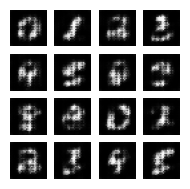

2/2 [==============================] - 0s 5ms/step
500: [dis: -0.798608, bce: 0.299782, ce: 0.255394, mi: -1.381695, mi: -1.325873, acc: 0.953125]
500: [Adv: -2.079035, bce: 1.362395, ce: 0.038132, mi: -3.535000, mi: -3.424124, acc: 0.984375]
2/2 [==============================] - 0s 7ms/step
501: [dis: -0.397010, bce: 0.345403, ce: 0.192236, mi: -1.275506, mi: -0.593792, acc: 0.953125]
501: [Adv: -3.098268, bce: 0.174845, ce: 0.042864, mi: -4.193967, mi: -2.437986, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
502: [dis: -0.682871, bce: 0.610688, ce: 0.298042, mi: -1.420176, mi: -1.763027, acc: 0.929688]
502: [Adv: 0.684711, bce: 3.529592, ce: 0.062631, mi: -3.495432, mi: -2.319591, acc: 0.968750]
2/2 [==============================] - 0s 6ms/step
503: [dis: -0.423404, bce: 0.997126, ce: 0.203946, mi: -0.961054, mi: -2.287898, acc: 0.960938]
503: [Adv: -2.876762, bce: 0.029303, ce: 0.034291, mi: -3.194771, mi: -2.685942, acc: 0.984375]
2/2 [========================

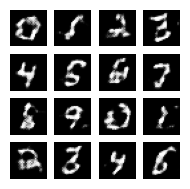

2/2 [==============================] - 0s 5ms/step
1000: [dis: -0.736085, bce: 0.691177, ce: 0.124202, mi: -1.462291, mi: -1.640638, acc: 0.960938]
1000: [Adv: -1.038458, bce: 1.814960, ce: 0.030306, mi: -2.588328, mi: -3.179121, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
1001: [dis: -0.461657, bce: 0.619985, ce: 0.148586, mi: -0.917996, mi: -1.542460, acc: 0.968750]
1001: [Adv: -2.398238, bce: 0.719894, ce: 0.036986, mi: -3.426242, mi: -2.883995, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
1002: [dis: -0.676189, bce: 0.601923, ce: 0.129953, mi: -1.739704, mi: -1.076428, acc: 0.968750]
1002: [Adv: -1.812206, bce: 1.479017, ce: 0.046685, mi: -3.848333, mi: -2.827481, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
1003: [dis: -1.525315, bce: 0.508461, ce: 0.079370, mi: -2.412181, mi: -1.814111, acc: 0.984375]
1003: [Adv: -2.333021, bce: 0.887144, ce: 0.057726, mi: -3.896783, mi: -2.658999, acc: 1.000000]
2/2 [===============

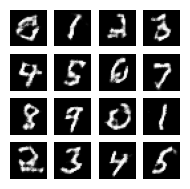

2/2 [==============================] - 0s 6ms/step
1500: [dis: -1.035411, bce: 0.768930, ce: 0.175340, mi: -2.335592, mi: -1.623770, acc: 0.945312]
1500: [Adv: -2.749299, bce: 0.563069, ce: 0.040234, mi: -3.640371, mi: -3.064833, acc: 0.984375]
2/2 [==============================] - 0s 11ms/step
1501: [dis: -0.680331, bce: 0.610016, ce: 0.086250, mi: -1.324656, mi: -1.428537, acc: 0.968750]
1501: [Adv: -1.039106, bce: 1.751060, ce: 0.044537, mi: -3.012224, mi: -2.657182, acc: 0.968750]
2/2 [==============================] - 0s 5ms/step
1502: [dis: -1.144637, bce: 0.528643, ce: 0.079532, mi: -1.729365, mi: -1.776259, acc: 0.984375]
1502: [Adv: -2.413835, bce: 0.734341, ce: 0.096769, mi: -3.113853, mi: -3.376036, acc: 0.953125]
2/2 [==============================] - 0s 5ms/step
1503: [dis: -0.914433, bce: 0.565152, ce: 0.053151, mi: -1.456890, mi: -1.608580, acc: 0.984375]
1503: [Adv: -1.256044, bce: 1.795965, ce: 0.030385, mi: -3.253476, mi: -2.911313, acc: 0.984375]
2/2 [==============

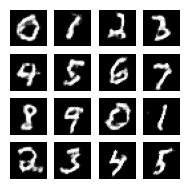

2/2 [==============================] - 0s 6ms/step
2000: [dis: -0.955944, bce: 0.561145, ce: 0.047621, mi: -0.951306, mi: -2.178114, acc: 0.968750]
2000: [Adv: -2.343817, bce: 0.815754, ce: 0.017163, mi: -3.591650, mi: -2.761817, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
2001: [dis: -1.528700, bce: 0.585964, ce: 0.019476, mi: -2.677135, mi: -1.591145, acc: 0.992188]
2001: [Adv: -1.285060, bce: 1.541746, ce: 0.010390, mi: -2.039706, mi: -3.634685, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
2002: [dis: -1.540524, bce: 0.626154, ce: 0.048040, mi: -2.067722, mi: -2.361715, acc: 0.992188]
2002: [Adv: -2.209974, bce: 0.732770, ce: 0.021228, mi: -3.225778, mi: -2.702166, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
2003: [dis: -0.969898, bce: 0.584315, ce: 0.071603, mi: -1.933445, mi: -1.318186, acc: 0.968750]
2003: [Adv: -1.135256, bce: 1.655040, ce: 0.005766, mi: -2.447417, mi: -3.144707, acc: 1.000000]
2/2 [===============

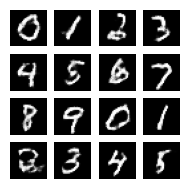

2/2 [==============================] - 0s 6ms/step
2500: [dis: -1.448793, bce: 0.640080, ce: 0.012247, mi: -2.423156, mi: -1.779084, acc: 1.000000]
2500: [Adv: -1.728515, bce: 0.863208, ce: 0.008937, mi: -2.477806, mi: -2.723515, acc: 1.000000]
2/2 [==============================] - 0s 4ms/step
2501: [dis: -1.256627, bce: 0.558121, ce: 0.119101, mi: -1.548074, mi: -2.319623, acc: 0.976562]
2501: [Adv: -0.859389, bce: 1.209188, ce: 0.049410, mi: -1.807306, mi: -2.428668, acc: 0.984375]
2/2 [==============================] - 0s 6ms/step
2502: [dis: -0.430631, bce: 0.612771, ce: 0.107402, mi: -0.889120, mi: -1.412490, acc: 0.968750]
2502: [Adv: -2.148635, bce: 0.832301, ce: 0.018474, mi: -3.595587, mi: -2.403232, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
2503: [dis: -0.253513, bce: 0.505296, ce: 0.082654, mi: -0.788605, mi: -0.894319, acc: 0.960938]
2503: [Adv: -2.502000, bce: 1.254613, ce: 0.065795, mi: -3.470309, mi: -4.174506, acc: 0.968750]
2/2 [===============

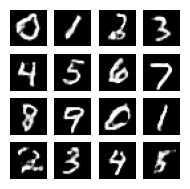

2/2 [==============================] - 0s 5ms/step
3000: [dis: -0.510296, bce: 0.611545, ce: 0.096268, mi: -0.912243, mi: -1.523978, acc: 0.968750]
3000: [Adv: -1.855555, bce: 0.728448, ce: 0.036343, mi: -2.252609, mi: -2.988084, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
3001: [dis: -0.288290, bce: 0.694546, ce: 0.065561, mi: -1.213024, mi: -0.883771, acc: 0.976562]
3001: [Adv: -1.937817, bce: 1.264695, ce: 0.005260, mi: -2.315741, mi: -4.099804, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
3002: [dis: -1.456177, bce: 0.634368, ce: 0.051654, mi: -1.973028, mi: -2.311370, acc: 0.976562]
3002: [Adv: -2.332853, bce: 0.600304, ce: 0.019989, mi: -3.549572, mi: -2.356719, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
3003: [dis: -0.575374, bce: 0.648781, ce: 0.059125, mi: -0.987085, mi: -1.579475, acc: 0.984375]
3003: [Adv: -1.337989, bce: 1.318439, ce: 0.082517, mi: -2.238061, mi: -3.239830, acc: 0.953125]
2/2 [===============

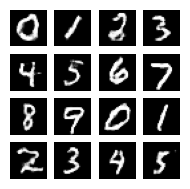

2/2 [==============================] - 0s 5ms/step
3500: [dis: -1.044196, bce: 0.634151, ce: 0.022114, mi: -1.730610, mi: -1.670311, acc: 1.000000]
3500: [Adv: -2.273620, bce: 0.864100, ce: 0.003774, mi: -3.813758, mi: -2.469229, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
3501: [dis: -1.472260, bce: 0.626382, ce: 0.042812, mi: -2.629891, mi: -1.653017, acc: 0.984375]
3501: [Adv: -0.778340, bce: 1.335199, ce: 0.006568, mi: -1.946276, mi: -2.293938, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
3502: [dis: -0.641636, bce: 0.619328, ce: 0.027782, mi: -1.300265, mi: -1.277228, acc: 0.992188]
3502: [Adv: -2.068653, bce: 0.736519, ce: 0.014401, mi: -3.363665, mi: -2.275481, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
3503: [dis: -1.186122, bce: 0.694274, ce: 0.067973, mi: -1.944258, mi: -1.952481, acc: 0.984375]
3503: [Adv: -2.053282, bce: 1.410642, ce: 0.059412, mi: -4.551300, mi: -2.495373, acc: 0.968750]
2/2 [===============

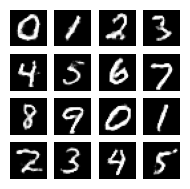

2/2 [==============================] - 0s 5ms/step
4000: [dis: -0.464982, bce: 0.553828, ce: 0.032224, mi: -0.988839, mi: -1.113228, acc: 0.992188]
4000: [Adv: -2.180747, bce: 1.021992, ce: 0.001574, mi: -2.878545, mi: -3.530079, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
4001: [dis: -0.397961, bce: 0.567952, ce: 0.013341, mi: -0.722877, mi: -1.235629, acc: 1.000000]
4001: [Adv: -2.353161, bce: 0.801513, ce: 0.002550, mi: -2.540572, mi: -3.773876, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
4002: [dis: -1.215757, bce: 0.539270, ce: 0.062956, mi: -1.992354, mi: -1.643611, acc: 0.976562]
4002: [Adv: -1.861378, bce: 1.067146, ce: 0.014264, mi: -2.320701, mi: -3.564876, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
4003: [dis: -0.607699, bce: 0.625904, ce: 0.037480, mi: -1.256617, mi: -1.285547, acc: 0.976562]
4003: [Adv: -1.436329, bce: 0.898327, ce: 0.061760, mi: -2.208303, mi: -2.584528, acc: 0.984375]
2/2 [===============

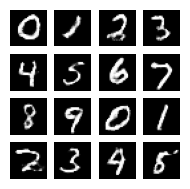

2/2 [==============================] - 0s 5ms/step
4500: [dis: -0.888757, bce: 0.615426, ce: 0.060444, mi: -1.669366, mi: -1.459888, acc: 0.984375]
4500: [Adv: -2.035194, bce: 0.840679, ce: 0.006042, mi: -2.457181, mi: -3.306649, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
4501: [dis: -0.725721, bce: 0.636956, ce: 0.057934, mi: -1.204823, mi: -1.636399, acc: 0.976562]
4501: [Adv: -1.808394, bce: 0.894316, ce: 0.010421, mi: -2.956713, mi: -2.469550, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
4502: [dis: -0.969744, bce: 0.593955, ce: 0.031287, mi: -1.804711, mi: -1.385260, acc: 0.992188]
4502: [Adv: -2.022191, bce: 1.059813, ce: 0.048931, mi: -2.950763, mi: -3.311106, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
4503: [dis: -1.037900, bce: 0.602487, ce: 0.002999, mi: -1.339425, mi: -1.947349, acc: 1.000000]
4503: [Adv: -2.211762, bce: 0.814098, ce: 0.003084, mi: -3.181715, mi: -2.876175, acc: 1.000000]
2/2 [===============

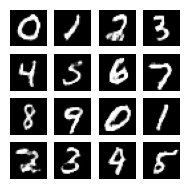

2/2 [==============================] - 0s 5ms/step
5000: [dis: -0.856564, bce: 0.558085, ce: 0.032893, mi: -1.541221, mi: -1.353862, acc: 0.992188]
5000: [Adv: -1.895479, bce: 1.080140, ce: 0.040560, mi: -2.737450, mi: -3.294908, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
5001: [dis: -1.749455, bce: 0.593044, ce: 0.023657, mi: -2.142313, mi: -2.589999, acc: 0.992188]
5001: [Adv: -2.593868, bce: 0.822989, ce: 0.004348, mi: -3.116966, mi: -3.725445, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
5002: [dis: -1.335590, bce: 0.646533, ce: 0.057571, mi: -1.566097, mi: -2.513292, acc: 0.984375]
5002: [Adv: -2.714059, bce: 1.059088, ce: 0.032509, mi: -3.547223, mi: -4.064089, acc: 0.984375]
2/2 [==============================] - 0s 4ms/step
5003: [dis: -0.636099, bce: 0.644797, ce: 0.122651, mi: -1.642778, mi: -1.164316, acc: 0.984375]
5003: [Adv: -2.534147, bce: 0.696318, ce: 0.003264, mi: -3.707592, mi: -2.759865, acc: 1.000000]
2/2 [===============

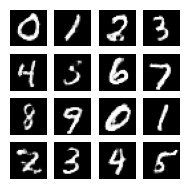

2/2 [==============================] - 0s 6ms/step
5500: [dis: -0.234717, bce: 0.662707, ce: 0.034552, mi: -0.950587, mi: -0.913365, acc: 0.984375]
5500: [Adv: -1.914950, bce: 0.953943, ce: 0.039795, mi: -2.836784, mi: -2.980593, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
5501: [dis: -0.700436, bce: 0.594095, ce: 0.020675, mi: -1.252574, mi: -1.377838, acc: 0.992188]
5501: [Adv: -2.608010, bce: 0.769512, ce: 0.014913, mi: -2.968612, mi: -3.816258, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
5502: [dis: -0.946178, bce: 0.663913, ce: 0.124424, mi: -1.942237, mi: -1.526793, acc: 0.992188]
5502: [Adv: -2.297034, bce: 0.961026, ce: 0.042824, mi: -2.248408, mi: -4.353360, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
5503: [dis: -1.013967, bce: 0.607074, ce: 0.016485, mi: -1.611412, mi: -1.663641, acc: 0.992188]
5503: [Adv: -1.975853, bce: 1.066178, ce: 0.001616, mi: -3.152481, mi: -2.934813, acc: 1.000000]
2/2 [===============

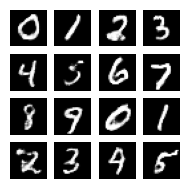

2/2 [==============================] - 0s 6ms/step
6000: [dis: -1.437615, bce: 0.624913, ce: 0.009508, mi: -2.331309, mi: -1.812763, acc: 1.000000]
6000: [Adv: -2.378310, bce: 0.995635, ce: 0.001359, mi: -2.528193, mi: -4.222414, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
6001: [dis: -0.973470, bce: 0.610324, ce: 0.016200, mi: -1.721101, mi: -1.478886, acc: 0.992188]
6001: [Adv: -2.546368, bce: 0.733539, ce: 0.001935, mi: -3.634236, mi: -2.929448, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
6002: [dis: -0.880897, bce: 0.641543, ce: 0.074722, mi: -0.922877, mi: -2.271445, acc: 0.984375]
6002: [Adv: -1.553715, bce: 1.124978, ce: 0.036746, mi: -2.084089, mi: -3.346788, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
6003: [dis: -0.762669, bce: 0.617066, ce: 0.037041, mi: -1.650403, mi: -1.183149, acc: 0.992188]
6003: [Adv: -2.378065, bce: 0.826115, ce: 0.020621, mi: -2.316418, mi: -4.133183, acc: 0.984375]
2/2 [===============

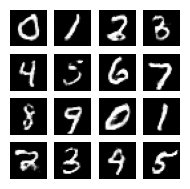

2/2 [==============================] - 0s 6ms/step
6500: [dis: -1.179388, bce: 0.652100, ce: 0.003897, mi: -1.685439, mi: -1.985331, acc: 1.000000]
6500: [Adv: -3.032798, bce: 0.685389, ce: 0.013695, mi: -4.556402, mi: -2.907361, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
6501: [dis: -0.583660, bce: 0.695157, ce: 0.009767, mi: -1.057247, mi: -1.519920, acc: 1.000000]
6501: [Adv: -2.496895, bce: 1.111534, ce: 0.000768, mi: -3.524125, mi: -3.694268, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
6502: [dis: -1.068821, bce: 0.613684, ce: 0.042433, mi: -1.855314, mi: -1.594561, acc: 0.992188]
6502: [Adv: -2.526834, bce: 0.815665, ce: 0.002754, mi: -3.506571, mi: -3.183935, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
6503: [dis: -1.287690, bce: 0.674471, ce: 0.006243, mi: -2.131754, mi: -1.805054, acc: 1.000000]
6503: [Adv: -2.299552, bce: 0.929880, ce: 0.001677, mi: -2.856800, mi: -3.605421, acc: 1.000000]
2/2 [===============

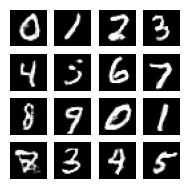

2/2 [==============================] - 0s 5ms/step
7000: [dis: -0.842690, bce: 0.642723, ce: 0.073311, mi: -2.191581, mi: -0.925867, acc: 0.984375]
7000: [Adv: -2.324676, bce: 1.147271, ce: 0.005128, mi: -3.250823, mi: -3.703329, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
7001: [dis: -1.197832, bce: 0.641117, ce: 0.008234, mi: -2.037004, mi: -1.657361, acc: 1.000000]
7001: [Adv: -2.855233, bce: 0.811078, ce: 0.001134, mi: -3.259865, mi: -4.075024, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
7002: [dis: -0.922097, bce: 0.640282, ce: 0.004984, mi: -1.691402, mi: -1.443323, acc: 1.000000]
7002: [Adv: -2.353793, bce: 0.984062, ce: 0.002434, mi: -3.307308, mi: -3.373270, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
7003: [dis: -1.434489, bce: 0.562334, ce: 0.074156, mi: -2.156652, mi: -1.985305, acc: 0.984375]
7003: [Adv: -1.743405, bce: 0.708568, ce: 0.027379, mi: -2.110394, mi: -2.848310, acc: 0.984375]
2/2 [===============

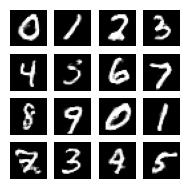

2/2 [==============================] - 0s 5ms/step
7500: [dis: -0.859598, bce: 0.626057, ce: 0.057871, mi: -1.706723, mi: -1.380327, acc: 0.992188]
7500: [Adv: -2.971789, bce: 0.767021, ce: 0.017700, mi: -3.605085, mi: -3.907936, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
7501: [dis: -0.600388, bce: 0.635931, ce: 0.006263, mi: -1.319409, mi: -1.165756, acc: 1.000000]
7501: [Adv: -1.629944, bce: 1.004786, ce: 0.000698, mi: -2.300321, mi: -2.970534, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
7502: [dis: -1.336432, bce: 0.612081, ce: 0.013760, mi: -2.373063, mi: -1.551485, acc: 1.000000]
7502: [Adv: -2.098218, bce: 0.657786, ce: 0.005831, mi: -3.044007, mi: -2.479662, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
7503: [dis: -1.068762, bce: 0.648083, ce: 0.002860, mi: -1.621850, mi: -1.817560, acc: 1.000000]
7503: [Adv: -2.046949, bce: 1.221640, ce: 0.001032, mi: -3.227595, mi: -3.311646, acc: 1.000000]
2/2 [===============

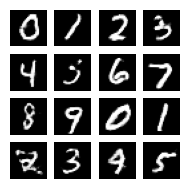

2/2 [==============================] - 0s 5ms/step
8000: [dis: -0.472247, bce: 0.677695, ce: 0.016527, mi: -1.458793, mi: -0.874144, acc: 0.992188]
8000: [Adv: -1.705856, bce: 0.845554, ce: 0.000844, mi: -2.002275, mi: -3.102232, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
8001: [dis: 0.039679, bce: 0.655003, ce: 0.053781, mi: -0.497204, mi: -0.841006, acc: 0.992188]
8001: [Adv: -2.051751, bce: 0.994448, ce: 0.003105, mi: -2.998161, mi: -3.100446, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
8002: [dis: -1.025864, bce: 0.642267, ce: 0.004769, mi: -1.617675, mi: -1.728126, acc: 1.000000]
8002: [Adv: -3.181962, bce: 0.805179, ce: 0.077688, mi: -4.045023, mi: -4.084635, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
8003: [dis: -1.079425, bce: 0.626517, ce: 0.015489, mi: -2.343981, mi: -1.098880, acc: 0.992188]
8003: [Adv: -2.251280, bce: 0.808709, ce: 0.007687, mi: -3.107741, mi: -3.027611, acc: 1.000000]
2/2 [================

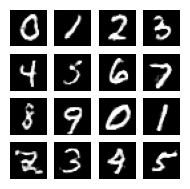

2/2 [==============================] - 0s 5ms/step
8500: [dis: -0.730030, bce: 0.699579, ce: 0.004169, mi: -2.044755, mi: -0.822802, acc: 1.000000]
8500: [Adv: -3.314590, bce: 0.825793, ce: 0.004285, mi: -4.219887, mi: -4.069448, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
8501: [dis: -1.292140, bce: 0.660918, ce: 0.015097, mi: -2.153739, mi: -1.782572, acc: 0.992188]
8501: [Adv: -1.911135, bce: 0.887611, ce: 0.008427, mi: -3.642479, mi: -1.971867, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
8502: [dis: -1.137318, bce: 0.612416, ce: 0.007601, mi: -1.794106, mi: -1.720564, acc: 1.000000]
8502: [Adv: -2.381210, bce: 1.012445, ce: 0.013766, mi: -3.513068, mi: -3.301775, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
8503: [dis: -1.428654, bce: 0.662740, ce: 0.040922, mi: -2.365026, mi: -1.899606, acc: 0.976562]
8503: [Adv: -2.219201, bce: 0.744996, ce: 0.024154, mi: -3.073087, mi: -2.903615, acc: 1.000000]
2/2 [===============

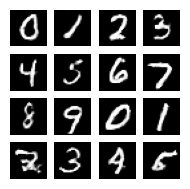

2/2 [==============================] - 0s 6ms/step
9000: [dis: -0.948604, bce: 0.665276, ce: 0.001035, mi: -1.545412, mi: -1.684419, acc: 1.000000]
9000: [Adv: -3.146738, bce: 0.745940, ce: 0.000950, mi: -4.022010, mi: -3.765246, acc: 1.000000]
2/2 [==============================] - 0s 6ms/step
9001: [dis: -0.086798, bce: 0.649616, ce: 0.043515, mi: -0.244062, mi: -1.315796, acc: 0.984375]
9001: [Adv: -1.976950, bce: 0.804576, ce: 0.046626, mi: -3.034615, mi: -2.621690, acc: 0.984375]
2/2 [==============================] - 0s 5ms/step
9002: [dis: -1.010985, bce: 0.623061, ce: 0.011384, mi: -1.091428, mi: -2.199431, acc: 0.992188]
9002: [Adv: -1.940801, bce: 1.024775, ce: 0.001220, mi: -3.578162, mi: -2.355430, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
9003: [dis: -0.548879, bce: 0.661671, ce: 0.064502, mi: -1.003567, mi: -1.546536, acc: 0.984375]
9003: [Adv: -2.510333, bce: 0.844792, ce: 0.026551, mi: -3.391285, mi: -3.372067, acc: 0.984375]
2/2 [===============

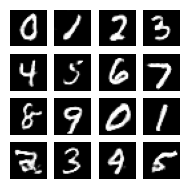

2/2 [==============================] - 0s 7ms/step
9500: [dis: -0.805906, bce: 0.660890, ce: 0.008930, mi: -0.997901, mi: -1.953551, acc: 1.000000]
9500: [Adv: -2.227034, bce: 0.749606, ce: 0.000496, mi: -2.392865, mi: -3.561406, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
9501: [dis: -1.055672, bce: 0.646289, ce: 0.064723, mi: -2.275185, mi: -1.258185, acc: 0.984375]
9501: [Adv: -1.770962, bce: 1.035578, ce: 0.002194, mi: -2.559692, mi: -3.057778, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
9502: [dis: -1.004511, bce: 0.665835, ce: 0.059377, mi: -1.931102, mi: -1.528345, acc: 0.992188]
9502: [Adv: -2.920185, bce: 0.715092, ce: 0.002862, mi: -3.434460, mi: -3.841817, acc: 1.000000]
2/2 [==============================] - 0s 5ms/step
9503: [dis: -0.713553, bce: 0.666314, ce: 0.023003, mi: -1.725152, mi: -1.080590, acc: 0.992188]
9503: [Adv: -1.561707, bce: 0.815508, ce: 0.000787, mi: -1.804800, mi: -2.951205, acc: 1.000000]
2/2 [===============

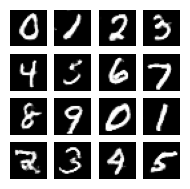

In [7]:
models = (generator, discriminator, adversarial)
data = (x_train, y_train)
params = (batch_size, latent_size, train_steps, num_labels, model_name)
train(models, data, params)

In [23]:
import matplotlib.image as mpimg

def load_images(image_dir):
    images = []
    filenames = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = mpimg.imread(img_path)
        images.append(img)
        filenames.append(filename)
    return images, filenames

def plot_images_in_grid(images, filenames, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(filenames[i], fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

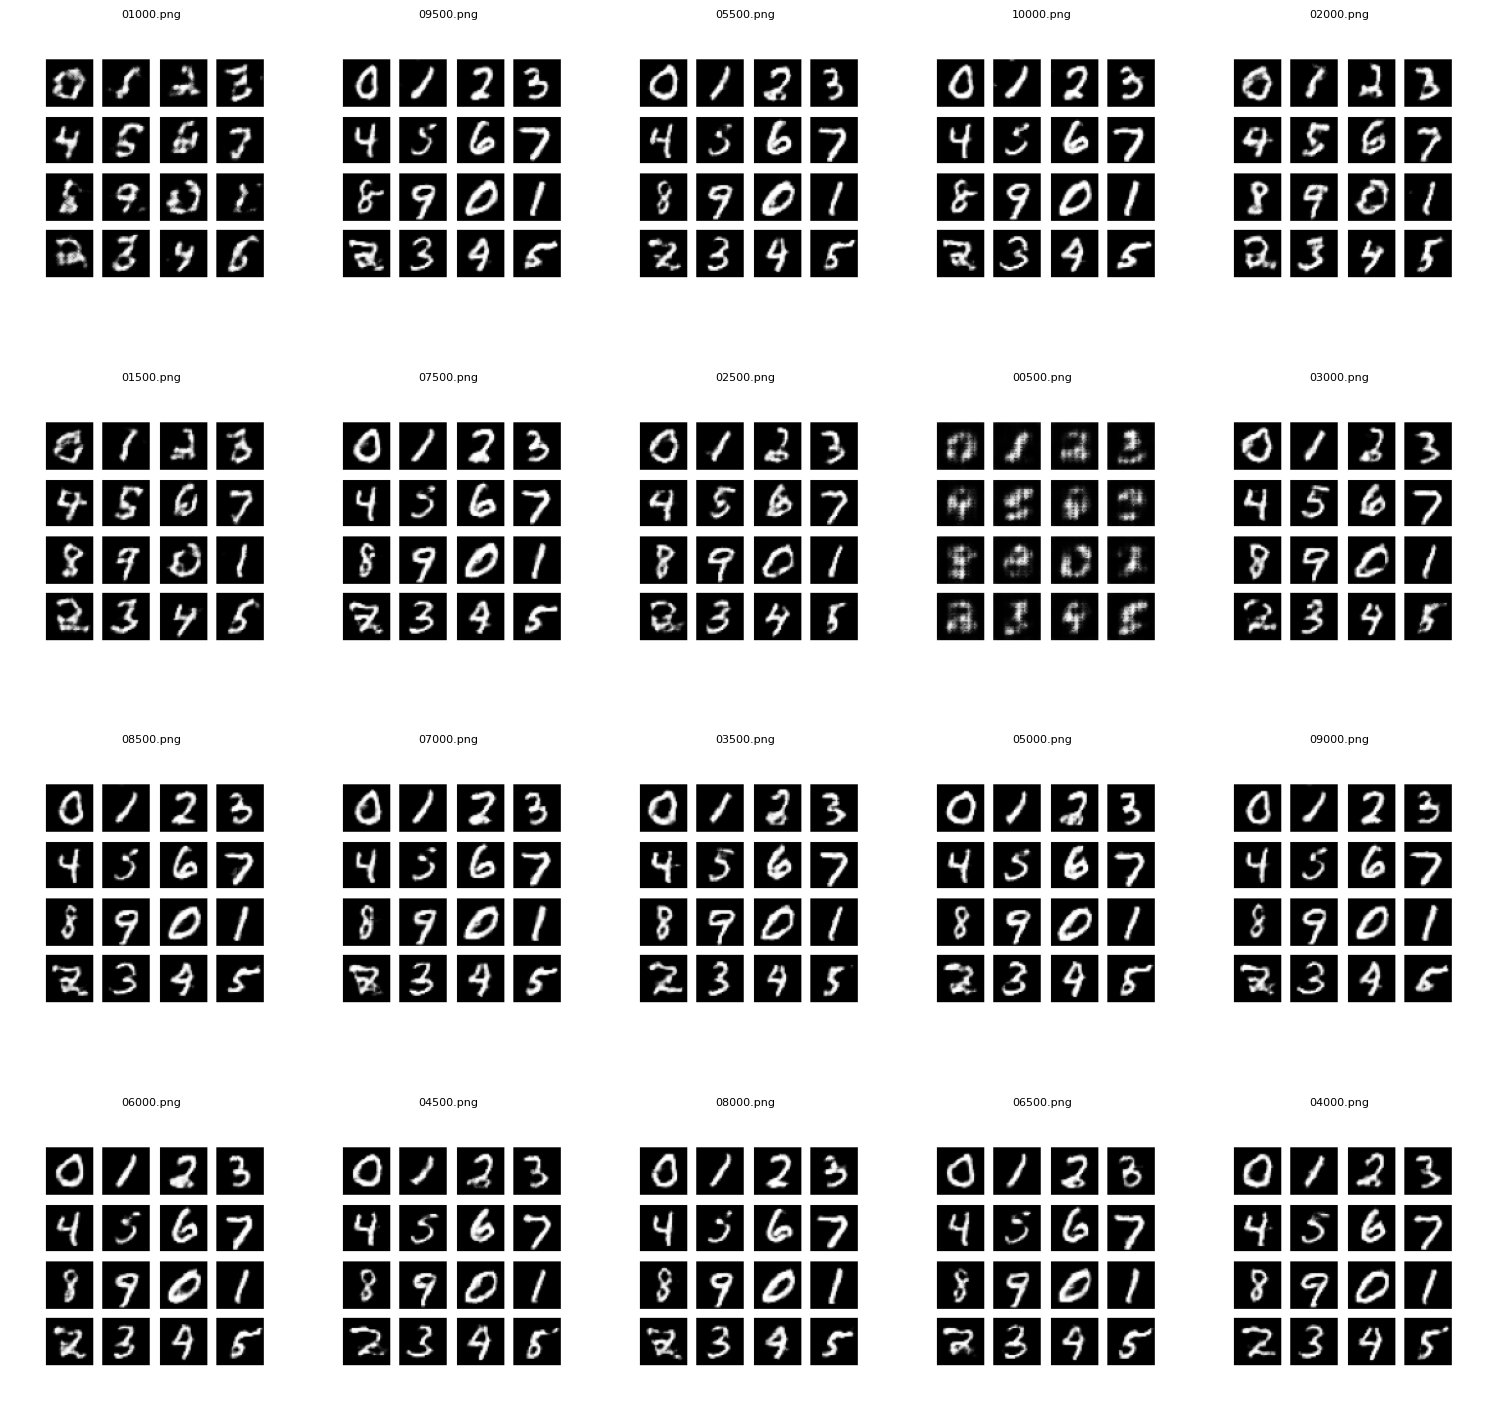

In [24]:
image_dir = '/content/infogan_mnist'
images, filenames = load_images(image_dir)
plot_images_in_grid(images, filenames, (4, 5))

10000.png is the last output